# Analysing PPG signals from smart rings

There's a range of Smart Rings that recently hit the market. Among other things they also record PPG signals on the finger, so let's dive into how to analyse these with HeartPy.

The example file I've included contains only the PPG signal in order to keep filesize low. Many smart rings also record skin response, acceleration and gyroscopic data. It was recorded at **32Hz**

In [1]:
#Let's import some packages first
import numpy as np
import matplotlib.pyplot as plt

import heartpy as hp

sample_rate = 32

In [2]:
#load the example file
data = hp.get_data('ring_data.csv')

#### First let's take a look at the whole signal

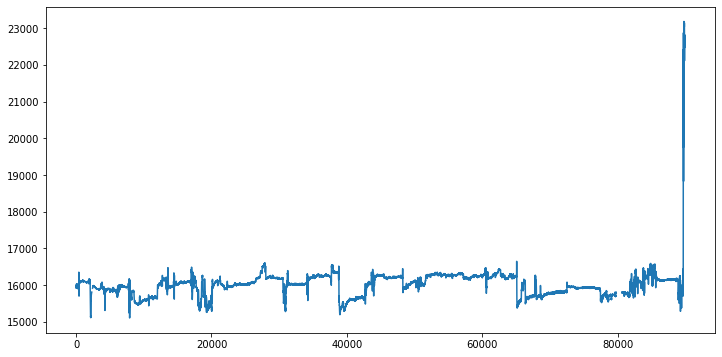

In [3]:
plt.figure(figsize=(12,6))
plt.plot(data)
plt.show()

#### I spot a few gaps. 

This means periods where the device outputs NaN values. Let's replace with numerical data (0's) otherwise some numerical parts of the analysis will fail.

Also let's plot the first 5 minutes and get a look at the signal

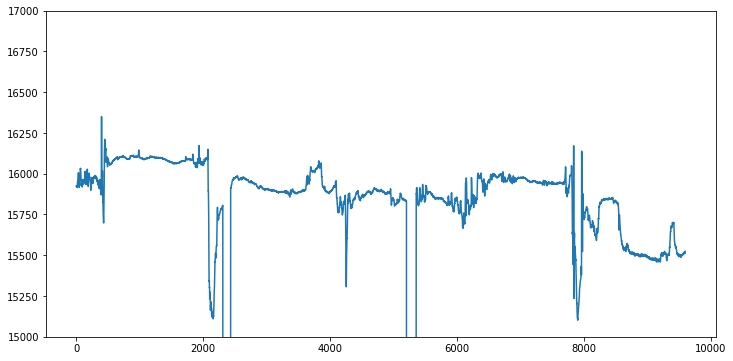

In [4]:
#missing pieces! Let's replace
data = np.nan_to_num(data)

#plot first 5 minutes
plt.figure(figsize=(12,6))
plt.plot(data[0:(5 * 60) * sample_rate])
plt.ylim(15000, 17000)
plt.show()

#### Doesn't seem like much of a signal is going on. Let's go to the second five minutes and zoom in a bit

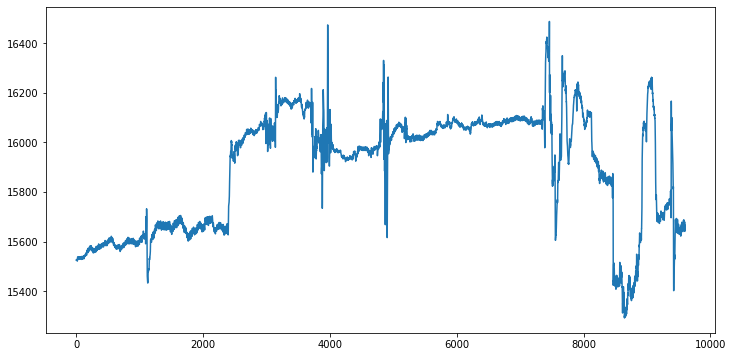

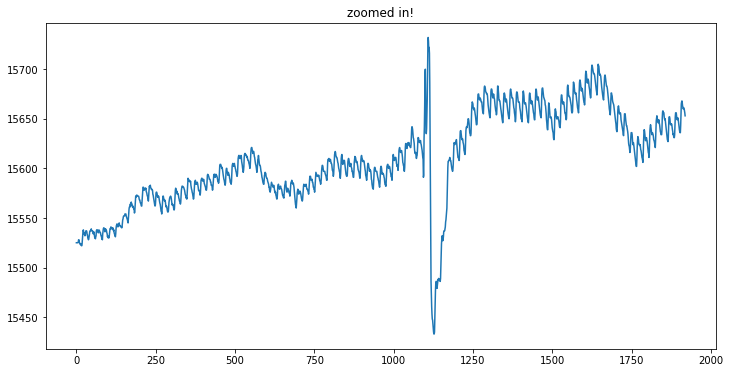

In [5]:
plt.figure(figsize=(12,6))
plt.plot(data[(5 * 60) * sample_rate:(10 * 60) * sample_rate])
plt.show()


plt.figure(figsize=(12,6))
plt.title('zoomed in!')
plt.plot(data[(5 * 60) * sample_rate:(6 * 60) * sample_rate])
plt.show()

#### It's not great but we definitely got a signal in this segment!

Analysing is relatively straightforward. We need to do a few standard signal processing tricks:

- filter the signal
- run the analysis
- visualise the analysis

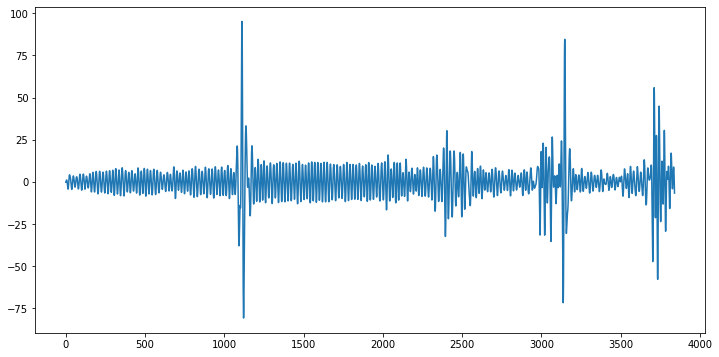

In [6]:
#First let's filter, there's a standard butterworth
#filter implementations available in HeartPy under
#filtersignal(). We will use the bandpass variant.
#we filter out frequencies below 0.8Hz (<= 48 bpm)
#and above 3Hz (>= 180 bpm)

filtered_ppg = hp.filter_signal(data[(5 * 60) * sample_rate:
                                     (10 * 60) * sample_rate], 
                                cutoff = [0.8, 2.5], 
                                filtertype = 'bandpass',
                                sample_rate = sample_rate, 
                                order = 3,
                                return_top = False)

#And let's plot the same segment as under 'zoomed in!' above
plt.figure(figsize=(12,6))
plt.plot(filtered_ppg[0:((2*60)*32)])
plt.show()

#### Well that does look a _lot_ better

In [7]:
#Run the analysis. Using 'high_precision' means a spline will
#be fitted to all peaks and then the maximum determined.
#this means we can have a much higher peak position accuracy than 
#the 32Hz would allow

wd, m = hp.process(filtered_ppg, sample_rate=sample_rate,
                   high_precision = True)

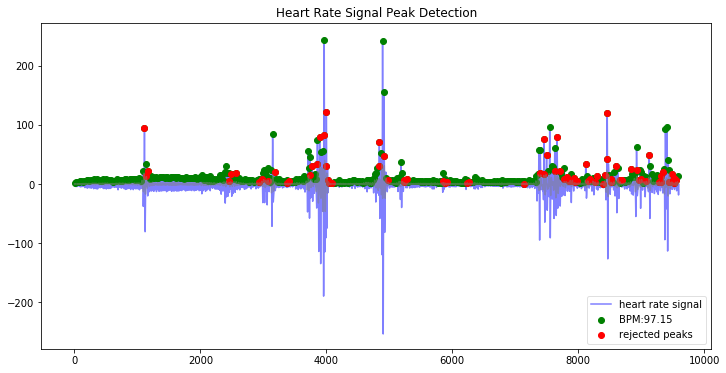

bpm: 97.147470
ibi: 617.617729
sdnn: 87.015029
sdsd: 83.851713
rmssd: 108.585723
pnn20: 0.746224
pnn50: 0.422961
hr_mad: 38.250000
sd1: 76.717543
sd2: 87.771097
s: 21154.174560
sd1/sd2: 0.874064
breathingrate: 0.450000


In [8]:
plt.figure(figsize=(12,6))
hp.plotter(wd, m)

for key in m.keys():
    print('%s: %f' %(key, m[key]))

#### Let's zoom in on the 5 minute segment minute by minute

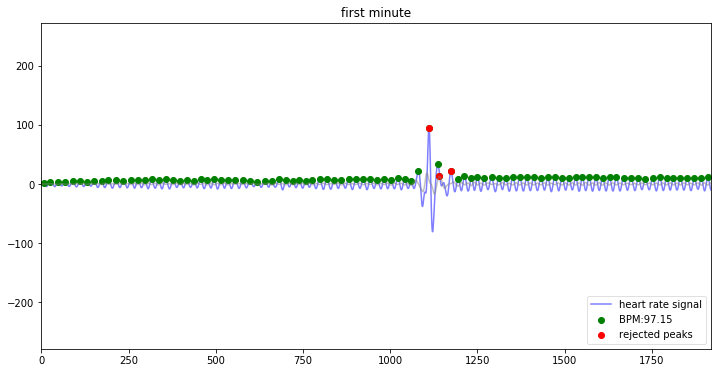

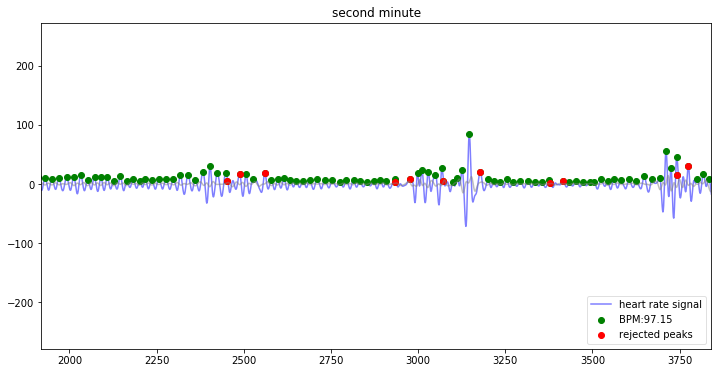

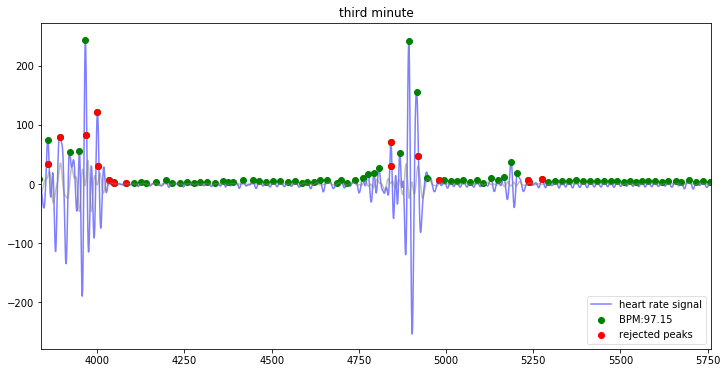

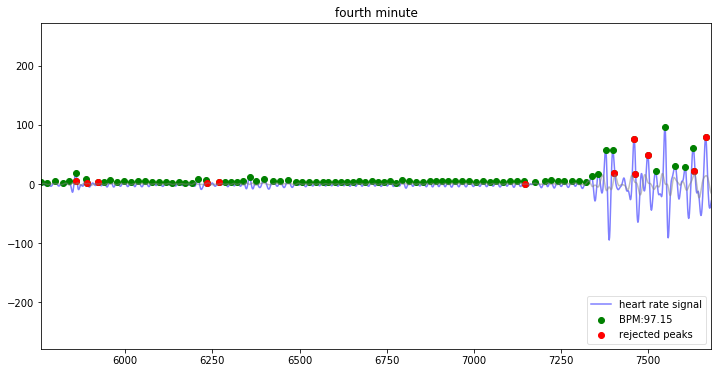

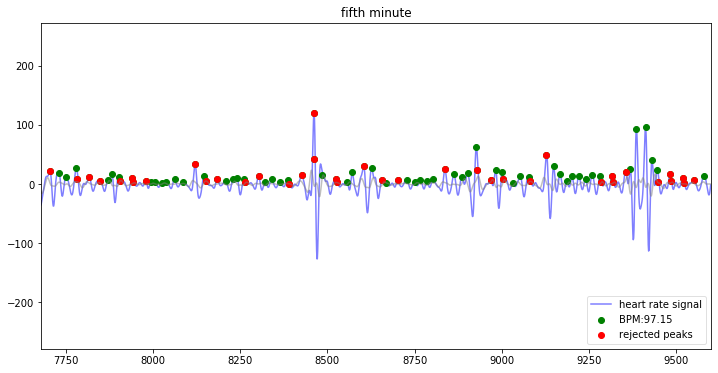

In [9]:
plt.figure(figsize=(12,6))
plt.xlim(0, (1 * 60) * sample_rate)
hp.plotter(wd, m, title='first minute')

plt.figure(figsize=(12,6))
plt.xlim((1 * 60) * sample_rate, (2 * 60) * sample_rate)
hp.plotter(wd, m, title='second minute')

plt.figure(figsize=(12,6))
plt.xlim((2 * 60) * sample_rate, (3 * 60) * sample_rate)
hp.plotter(wd, m, title='third minute')

plt.figure(figsize=(12,6))
plt.xlim((3 * 60) * sample_rate, (4 * 60) * sample_rate)
hp.plotter(wd, m, title='fourth minute')

plt.figure(figsize=(12,6))
plt.xlim((4 * 60) * sample_rate, (5 * 60) * sample_rate)
hp.plotter(wd, m, title='fifth minute')

Even though the signal is quite faint, it is still possible to extract the vast majority of peaks from it.

Now the last segment is noisy even after filtering, which in combination with the smart ring as a source (low amplitude, low sample rate!) results in some incorrect acceptances. This causes high values of RMSSD, SDNN and SDSD, pNN20 and pNN50, which are sensitive to outliers.

HeartPy comes with an option to clean the peak-peak intervals prior to analysis. It will attempt to identify and reject outliers. This works better the longer the signal is! After all, if there's many 'good' peak-peak intervals to relatively few 'bad' ones, outlier detection works better.

Available methods to detect outiers are 'quotient-filter', 'iqr' (based on the interquartile range) and 'z-score' (based on the modified z-score method). Default is 'quotient-filter'

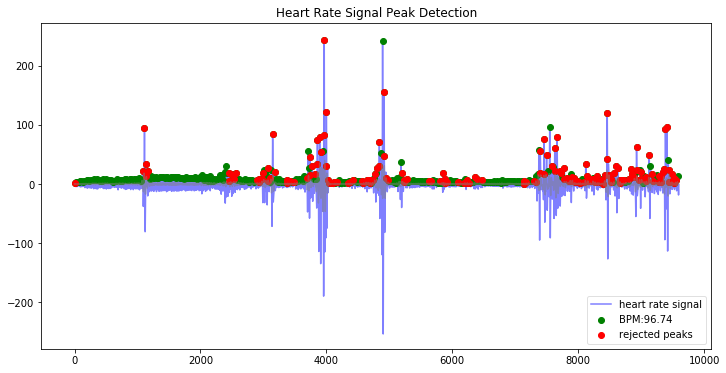

bpm: 96.741497
ibi: 620.209547
sdnn: 66.367245
sdsd: 87.034149
rmssd: 87.038704
pnn20: 0.370130
pnn50: 0.198052
hr_mad: 34.250000
sd1: 33.838365
sd2: 60.948770
s: 6479.241722
sd1/sd2: 0.555194
breathingrate: 0.390000


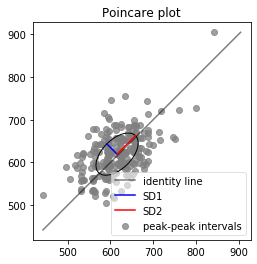

In [14]:
wd, m = hp.process(filtered_ppg, sample_rate=sample_rate,
                   high_precision = True, clean_rr = True)

plt.figure(figsize=(12,6))
hp.plotter(wd, m)

for key in m.keys():
    print('%s: %f' %(key, m[key]))
    
#and plot poincare
hp.plot_poincare(wd, m)

All HRV measures have dropped to acceptable ranges, indicative of us having found a few outliers (likely in the last minute segment).

While HeartPy handles these signals just fine, the best way to avoid this is to use a higher sampling rate and ensure good signal quality. Both make it easier for HeartPy to detect beats.